In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
# 设置中文字体为 SimHei（黑体）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体 SimHei
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

In [2]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
device='cuda:0' if torch.cuda.is_available() else 'cpu'

def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

划分训练集和测试集

In [6]:
df_suzhou=pd.read_excel("./data/安庆12.xlsx")
df_suzhou['日期'] = pd.to_datetime(df_suzhou['日期'])
X1_suzhou=df_suzhou.drop(columns=['平均负荷','碳排放强度','排汽温度', '日期','机组'])
y1_suzhou=df_suzhou['碳排放强度']

df_maanshan=pd.read_excel("./data/马鞍山.xlsx")
df_maanshan['日期'] = pd.to_datetime(df_maanshan['日期'])
X1 = df_maanshan.drop(columns=['平均负荷','碳排放强度','排汽温度', '日期'])
y1 = df_maanshan['碳排放强度']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

1.SVM

In [7]:
# 创建并训练SVR模型
svr_model = SVR(gamma=0.005,C=1000)
svr_model.fit(X1_suzhou, y1_suzhou)
# 提取嫁接特征
svm_y_pred_AonB = svr_model.predict(X1_train)
svm_y_pred_AonB_as_test = svr_model.predict(X1_test)
# print(X1_train)
# print(svm_y_pred_AonB)
# 拼接特征
XB_with_graft=np.hstack((X1_train,pd.DataFrame({'AonB':svm_y_pred_AonB})))
XB_with_graft_as_test=np.hstack((X1_test,pd.DataFrame({'AonB':svm_y_pred_AonB_as_test})))
# 训练新模型
svr_model.fit(XB_with_graft,y1_train)
# 预测
svm_y_pred = svr_model.predict(XB_with_graft_as_test)
# 评估模型
svm_mse = mean_squared_error(y1_test, svm_y_pred)
svm_rmse = np.sqrt(svm_mse)
svm_mae = mean_absolute_error(y1_test, svm_y_pred)
svm_mape = mean_absolute_percentage_error(y1_test, svm_y_pred)
svm_r2 = r2_score(y1_test, svm_y_pred)

print(f"svm_MSE: {svm_mse:.6f}")
print(f"svm_RMSE: {svm_rmse:.6f}")
print(f"svm_MAE: {svm_mae:.6f}")
print(f"svm_MAPE: {svm_mape*100:.6f}")
print(f"svm_R Square: {svm_r2:.6f}")

svm_MSE: 16897.214550
svm_RMSE: 129.989286
svm_MAE: 100.473757
svm_MAPE: 18.967284
svm_R Square: 0.486304


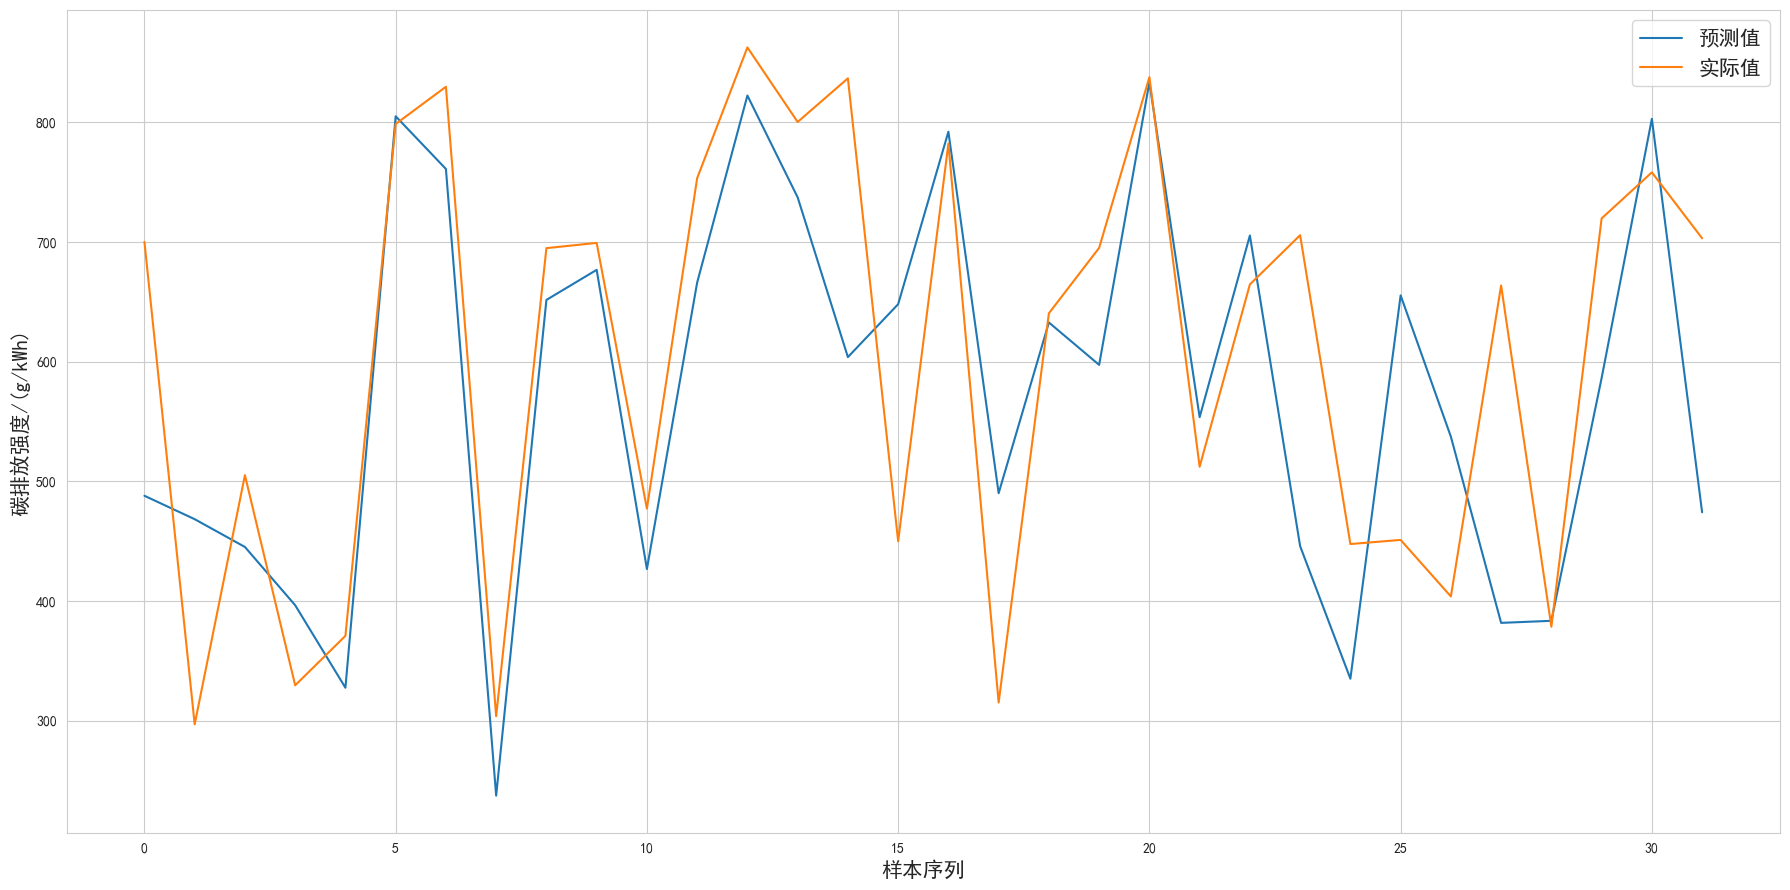

In [8]:

# 绘制test data预测值和真实值
plt.figure(figsize=(18, 9))
plt.plot(svm_y_pred, label='预测值')       # 添加预测值的标签
plt.plot(y1_test.values, label='实际值')  # 添加真实值的标签

# 显示图例
plt.legend(fontsize=15)
plt.xlabel("样本序列",fontsize = 15,fontweight='bold')
plt.ylabel("碳排放强度/(g/kWh)",fontsize = 15,fontweight='bold')

# 显示图表
plt.tight_layout()  # 调整布局，确保所有元素不重叠
# plt.savefig("svm.png",dpi=500,bbox_inches='tight')
plt.show()

2.XGB

In [9]:
from xgboost import XGBRegressor
# 初始化XGBoost回归器
xgb_model = XGBRegressor(
    n_estimators=150,        # 树的数量
    max_depth=5,             # 树的最大深度
    learning_rate=0.1,       # 学习率
    subsample=0.8,           # 每棵树使用的样本比例
    colsample_bytree=0.8,    # 每棵树使用的特征比例
    # random_state=42
)
# 训练模型
xgb_model.fit(X1_suzhou, y1_suzhou)
# 提取嫁接特征
xgb_y_pred_AonB = xgb_model.predict(X1_train)
xgb_y_pred_AonB_as_test = xgb_model.predict(X1_test)
# 拼接特征
XB_with_graft=np.hstack((X1_train,pd.DataFrame({'AonB':xgb_y_pred_AonB})))
XB_with_graft_as_test=np.hstack((X1_test,pd.DataFrame({'AonB':xgb_y_pred_AonB_as_test})))
# 训练新模型
xgb_model.fit(XB_with_graft,y1_train)
# 预测
xgb_y_pred = xgb_model.predict(XB_with_graft_as_test)
# 评估模型
xgb_mse = mean_squared_error(y1_test, xgb_y_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(y1_test, xgb_y_pred)
xgb_mape = mean_absolute_percentage_error(y1_test, xgb_y_pred)
xgb_r2 = r2_score(y1_test, xgb_y_pred)

print(f"xgb_MSE: {xgb_mse:.6f}")
print(f"xgb_RMSE: {xgb_rmse:.6f}")
print(f"xgb_MAE: {xgb_mae:.6f}")
print(f"xgb_MAPE: {xgb_mape*100:.6f}")
print(f"xgb_R Square: {xgb_r2:.6f}")

xgb_MSE: 14437.271019
xgb_RMSE: 120.155196
xgb_MAE: 94.958570
xgb_MAPE: 16.889506
xgb_R Square: 0.561089


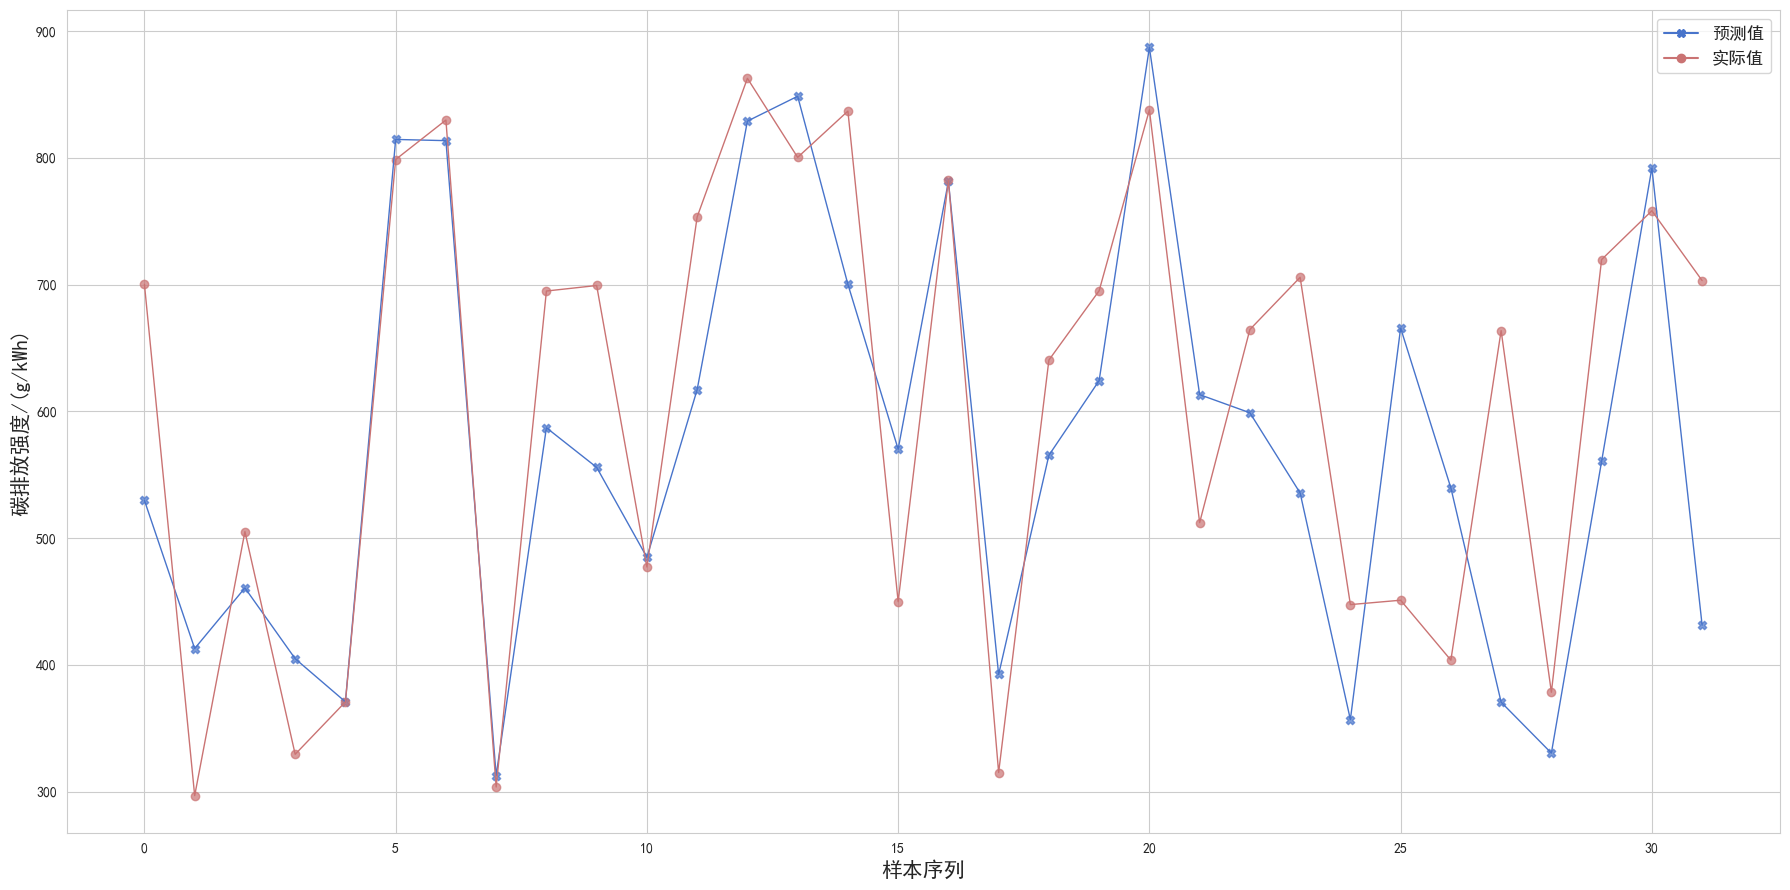

In [10]:
import matplotlib.lines as mlines  # 导入 mlines
# 绘制test data预测值和真实值
plt.figure(figsize=(18, 9))
plt.plot(xgb_y_pred, label='预测值', linewidth=1,color = "#4874CB")       # 添加预测值的标签
plt.plot(y1_test.values, label='实际值', linewidth=1, color='#CA7373')  # 添加真实值的标签
# 绘制test data的预测值和真实值
plt.scatter(range(len(xgb_y_pred)), xgb_y_pred, label='预测值',  alpha=0.7,marker= "X",color = "#4874CB")  # 绘制预测值的散点图
plt.scatter(range(len(y1_test.values)), y1_test.values, label='实际值', alpha=0.7, color='#CA7373')  # 绘制真实值的散点图
# 创建自定义的图例（线+点）
line1 = mlines.Line2D([], [], color="#4874CB", marker="X", markersize=6, label="预测值")
line2 = mlines.Line2D([], [], color="#CA7373", marker="o", markersize=6, label="实际值")

# 显示图例
plt.legend(handles=[line1, line2], fontsize=12.5)
plt.xlabel("样本序列",fontsize = 15,fontweight='bold')
plt.ylabel("碳排放强度/(g/kWh)",fontsize = 15,fontweight='bold')

# 显示图表
plt.tight_layout()  # 调整布局，确保所有元素不重叠
# plt.savefig("xgb1.png",dpi=500,bbox_inches='tight')
plt.show()

3.RF

In [11]:
correlation_matrix = df_maanshan.drop(columns=['排汽温度', '日期']).corr()
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_jobs=28,max_depth=7)
# rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X1_suzhou, y1_suzhou)
# 提取嫁接特征
rf_y_pred_AonB = rf_model.predict(X1_train)
rf_y_pred_AonB_as_test = rf_model.predict(X1_test)
# 拼接特征
XB_with_graft=np.hstack((X1_train,pd.DataFrame({'AonB':rf_y_pred_AonB})))
XB_with_graft_as_test=np.hstack((X1_test,pd.DataFrame({'AonB':rf_y_pred_AonB_as_test})))
# 训练新模型
rf_model.fit(XB_with_graft,y1_train)
# 预测
rf_y_pred = rf_model.predict(XB_with_graft_as_test)
# 评估模型
rf_mse = mean_squared_error(y1_test, rf_y_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y1_test, rf_y_pred)
rf_mape = mean_absolute_percentage_error(y1_test, rf_y_pred)
rf_r2 = r2_score(y1_test, rf_y_pred)

print(f"rf_MSE: {rf_mse:.6f}")
print(f"rf_RMSE: {rf_rmse:.6f}")
print(f"rf_MAE: {rf_mae:.6f}")
print(f"rf_MAPE: {rf_mape*100:.6f}")
print(f"rf_R Square: {rf_r2:.6f}")

rf_MSE: 14911.517908
rf_RMSE: 122.112726
rf_MAE: 96.857040
rf_MAPE: 17.258150
rf_R Square: 0.546671


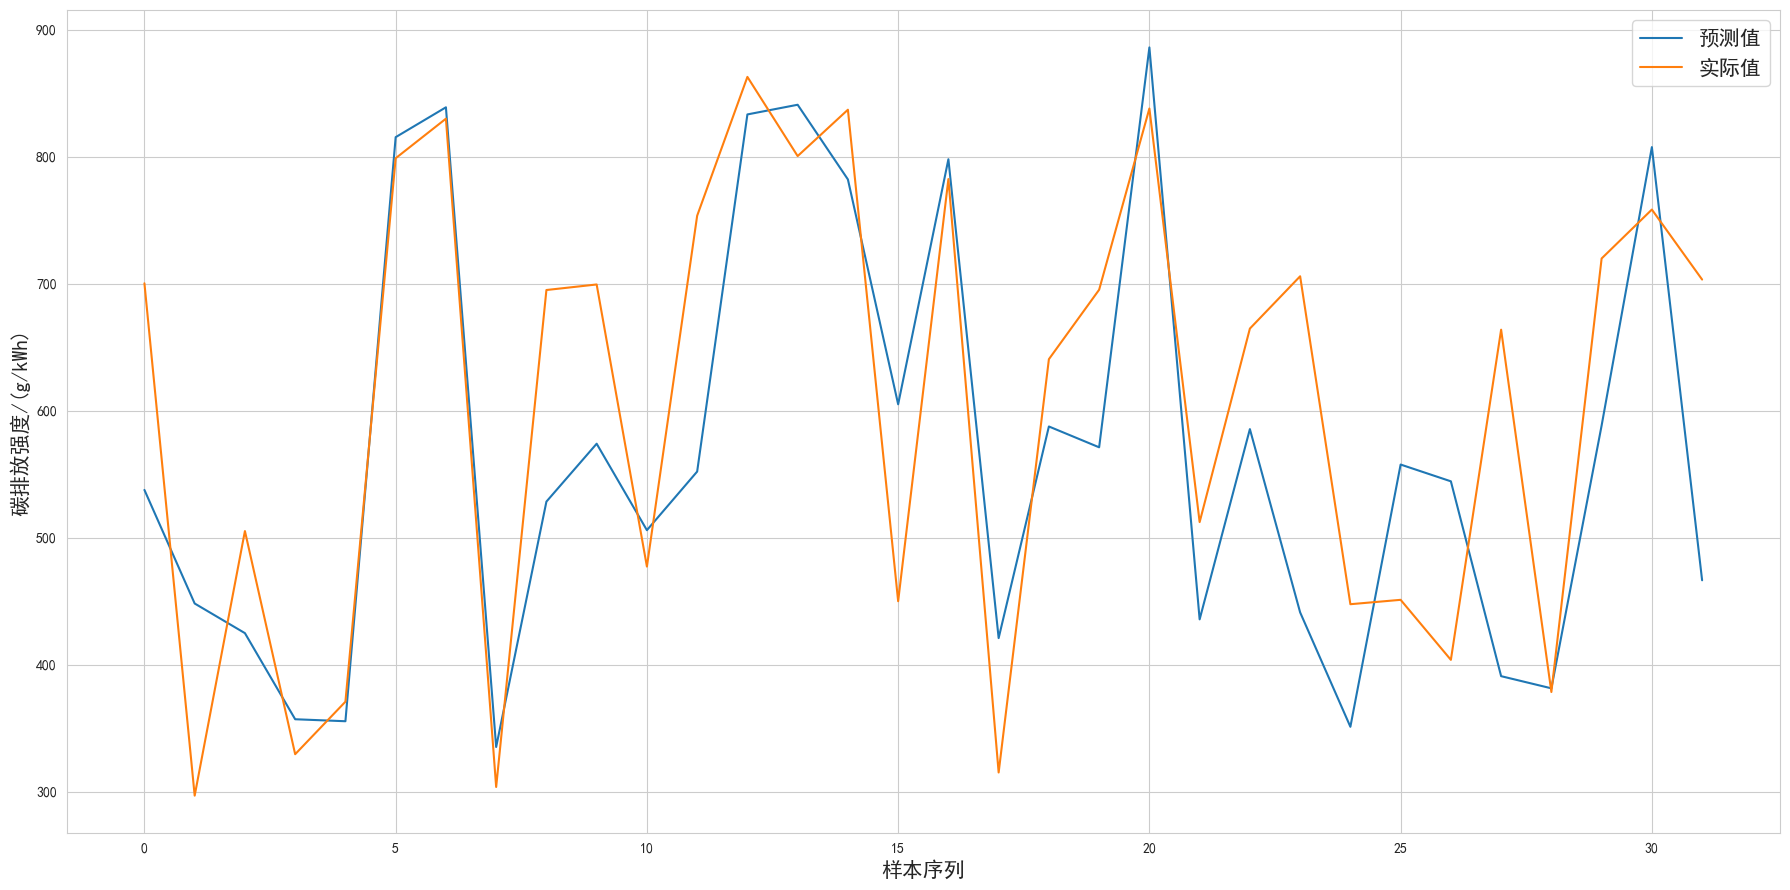

In [12]:
# 绘制test data预测值和真实值
plt.figure(figsize=(18, 9))
plt.plot(rf_y_pred, label='预测值')       # 添加预测值的标签
plt.plot(y1_test.values, label='实际值')  # 添加真实值的标签

# 显示图例
plt.legend(fontsize=15)
plt.xlabel("样本序列",fontsize = 15,fontweight='bold')
plt.ylabel("碳排放强度/(g/kWh)",fontsize = 15,fontweight='bold')

# 显示图表
plt.tight_layout()  # 调整布局，确保所有元素不重叠
# plt.savefig("svm.png",dpi=500,bbox_inches='tight')
plt.show()

4.LR

In [13]:
from sklearn.linear_model import LinearRegression
# 创建线性回归模型
lr_model = LinearRegression()
lr_model.fit(X1_suzhou, y1_suzhou)
# 提取嫁接特征
lr_y_pred_AonB = lr_model.predict(X1_train)
lr_y_pred_AonB_as_test = lr_model.predict(X1_test)
# 拼接特征
XB_with_graft=np.hstack((X1_train,pd.DataFrame({'AonB':lr_y_pred_AonB})))
XB_with_graft_as_test=np.hstack((X1_test,pd.DataFrame({'AonB':lr_y_pred_AonB_as_test})))
# 训练新模型
lr_model.fit(XB_with_graft,y1_train)
# 预测
lr_y_pred = lr_model.predict(XB_with_graft_as_test)
# 评估模型
lr_mse = mean_squared_error(y1_test, lr_y_pred)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y1_test, lr_y_pred)
lr_mape = mean_absolute_percentage_error(y1_test, lr_y_pred)
lr_r2 = r2_score(y1_test, lr_y_pred)

print(f"lr_MSE: {lr_mse:.6f}")
print(f"lr_RMSE: {lr_rmse:.6f}")
print(f"lr_MAE: {lr_mae:.6f}")
print(f"lr_MAPE: {lr_mape*100:.6f}")
print(f"lr_R Square: {lr_r2:.6f}")

lr_MSE: 15756.495000
lr_RMSE: 125.524878
lr_MAE: 102.302248
lr_MAPE: 19.835896
lr_R Square: 0.520983


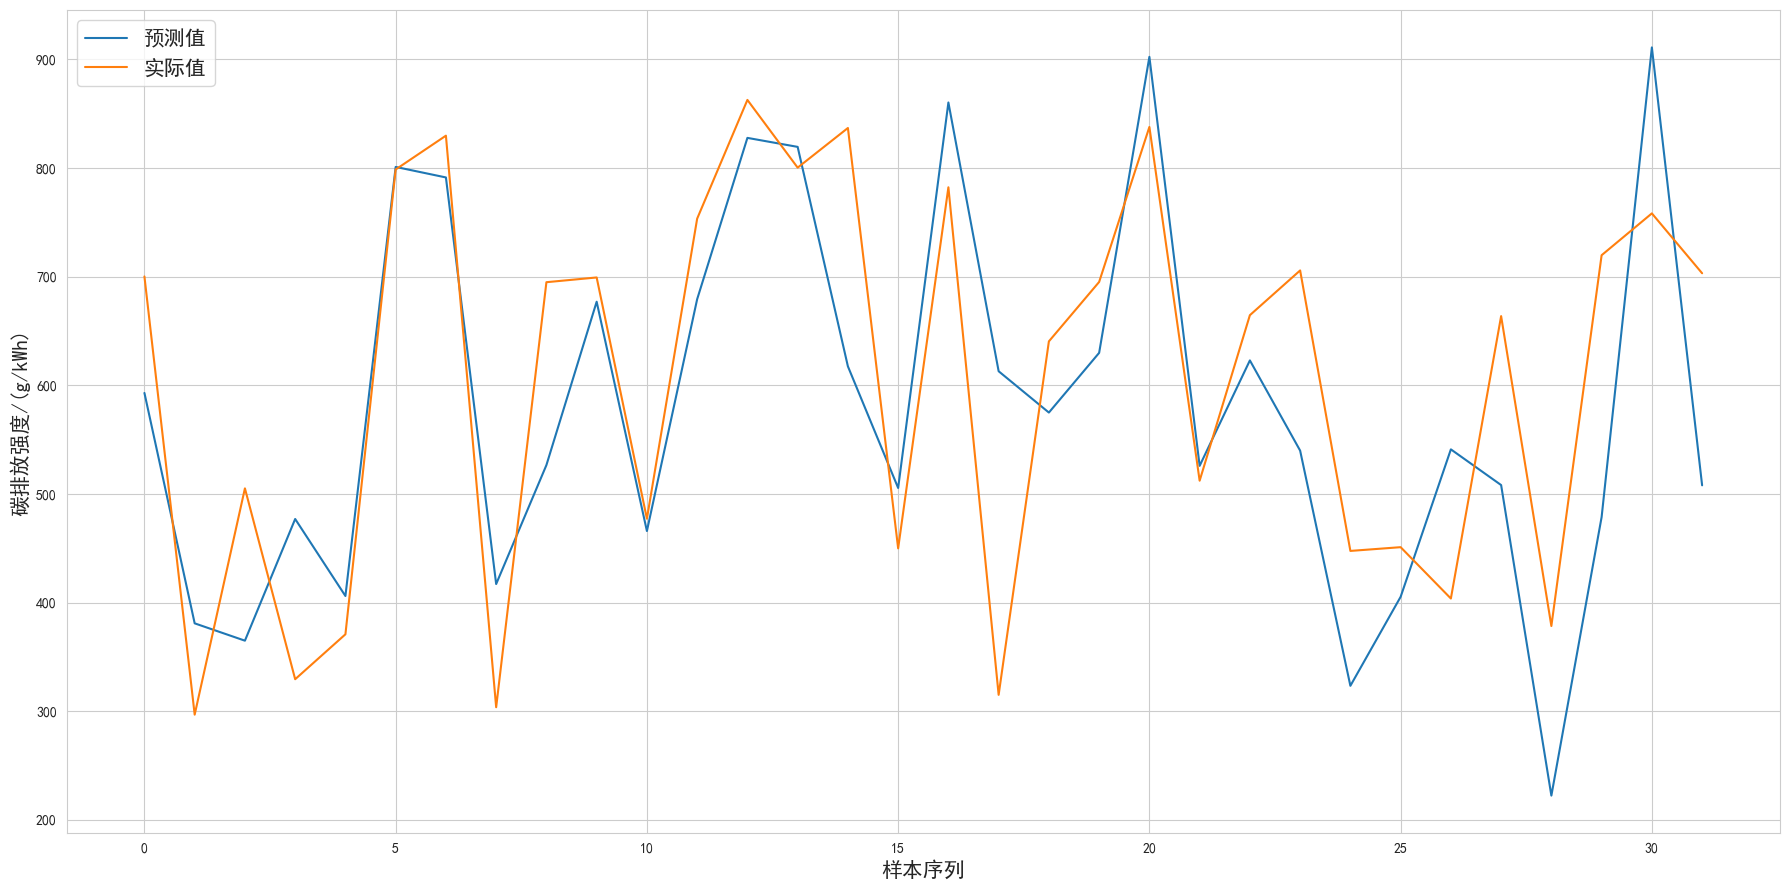

In [14]:
# 绘制test data预测值和真实值
plt.figure(figsize=(18, 9))
plt.plot(lr_y_pred, label='预测值')       # 添加预测值的标签
plt.plot(y1_test.values, label='实际值')  # 添加真实值的标签

# 显示图例
plt.legend(fontsize=15)
plt.xlabel("样本序列",fontsize = 15,fontweight='bold')
plt.ylabel("碳排放强度/(g/kWh)",fontsize = 15,fontweight='bold')

# 显示图表
plt.tight_layout()  # 调整布局，确保所有元素不重叠
# plt.savefig("svm.png",dpi=500,bbox_inches='tight')
plt.show()

5.DNN

In [15]:
device='cuda:0' if torch.cuda.is_available() else 'cpu'
set_seed(42)
# 数据标准化
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
scaler3 = MinMaxScaler()
X1_suzhou_scaled=scaler1.fit_transform(X1_suzhou)
y1_suzhou_scaled=scaler1.fit_transform(y1_suzhou.to_frame())
X1_train_scaled=scaler2.fit_transform(X1_train)
y1_train_scaled=scaler2.fit_transform(y1_train.to_frame())
X1_test_scaled=scaler3.fit_transform(X1_test)
y1_test_scaled=scaler3.fit_transform(y1_test.to_frame())
# 转为Tensor
X1_suzhou_tensor=torch.FloatTensor(X1_suzhou_scaled).to(device)
y1_suzhou_tensor=torch.FloatTensor(y1_suzhou_scaled).view(-1,1).to(device)
X1_train_tensor=torch.FloatTensor(X1_train_scaled).to(device)
y1_train_tensor=torch.FloatTensor(y1_train_scaled).view(-1,1).to(device)
X1_test_tensor=torch.FloatTensor(X1_test_scaled).to(device)
y1_test_tensor=torch.FloatTensor(y1_test_scaled).view(-1,1).to(device)

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # 第一个隐藏层
        self.fc2 = nn.Linear(64, 32)          # 第二个隐藏层
        self.fc3 = nn.Linear(32, 1)           # 输出层

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
# 1. 训练基础模型 Model A
# 初始化模型
input_size = X1_suzhou.shape[1]
model_a = SimpleNN(input_size).to(device)
# 定义损失函数和优化器
criterion = nn.MSELoss().to(device)  # 均方误差损失
optimizer = optim.SGD(model_a.parameters(), lr=0.17)
# 训练模型
num_epochs = 5000
for epoch in range(num_epochs):
    model_a.train()  # 设定训练模式
    optimizer.zero_grad()  # 梯度清零
    outputs = model_a(X1_suzhou_tensor)  # 前向传播
    loss = criterion(outputs, y1_suzhou_tensor)  # 计算损失
    loss.backward()  # 反向传播
    optimizer.step()  # 更新权重

    if (epoch + 1) % 200 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# 2. 提取嫁接特征
model_a.eval()  # 切换到评估模式
with torch.no_grad():
    dnn_y_pred_AonB = model_a(X1_train_tensor)  # 预测
    dnn_y_pred_AonB_as_test = model_a(X1_test_tensor)
# 拼接特征
XB_with_graft=np.hstack((X1_train_scaled,pd.DataFrame({'AonB':dnn_y_pred_AonB.cpu().numpy().flatten()})))
XB_with_graft_as_test=np.hstack((X1_test_scaled,pd.DataFrame({'AonB':dnn_y_pred_AonB_as_test.cpu().numpy().flatten()})))
XB_with_graft_tensor=torch.FloatTensor(XB_with_graft).to(device)
XB_with_graft_as_test_tensor=torch.FloatTensor(XB_with_graft_as_test).to(device)
# 训练新模型
# 初始化模型
input_size_b = XB_with_graft.shape[1]
model_b = SimpleNN(input_size_b).to(device)
# 定义损失函数和优化器
criterion = nn.MSELoss().to(device)  # 均方误差损失
optimizer = optim.SGD(model_b.parameters(), lr=0.05)
# 训练模型b
num_epochs = 2000
for epoch in range(num_epochs):
    model_b.train()  # 设定训练模式
    optimizer.zero_grad()  # 梯度清零
    outputs = model_b(XB_with_graft_tensor)  # 前向传播
    loss = criterion(outputs, y1_train_tensor)  # 计算损失
    loss.backward()  # 反向传播
    optimizer.step()  # 更新权重

    if (epoch + 1) % 200 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
# 预测
model_b.eval()  # 切换到评估模式
with torch.no_grad():
    dnn_y_pred_B = model_b(XB_with_graft_as_test_tensor)  # 预测
# 评估模型
dnn_y_pred_B=dnn_y_pred_B.cpu().numpy().flatten()
dnn_y_pred_B=scaler3.inverse_transform(pd.DataFrame({'pred':dnn_y_pred_B}))

dnn_mse = mean_squared_error(y1_test, dnn_y_pred_B)
dnn_rmse = np.sqrt(dnn_mse)
dnn_mae = mean_absolute_error(y1_test, dnn_y_pred_B)
dnn_mape = mean_absolute_percentage_error(y1_test, dnn_y_pred_B)
dnn_r2 = r2_score(y1_test, dnn_y_pred_B)

print(f"dnn_MSE: {dnn_mse:.6f}")
print(f"dnn_RMSE: {dnn_rmse:.6f}")
print(f"dnn_MAE: {dnn_mae:.6f}")
print(f"dnn_MAPE: {dnn_mape*100:.6f}")
print(f"dnn_R Square: {dnn_r2:.6f}")

Epoch [200/5000], Loss: 0.0150
Epoch [400/5000], Loss: 0.0129
Epoch [600/5000], Loss: 0.0117
Epoch [800/5000], Loss: 0.0113
Epoch [1000/5000], Loss: 0.0108
Epoch [1200/5000], Loss: 0.0107
Epoch [1400/5000], Loss: 0.0103
Epoch [1600/5000], Loss: 0.0096
Epoch [1800/5000], Loss: 0.0098
Epoch [2000/5000], Loss: 0.0097
Epoch [2200/5000], Loss: 0.0092
Epoch [2400/5000], Loss: 0.0091
Epoch [2600/5000], Loss: 0.0090
Epoch [2800/5000], Loss: 0.0090
Epoch [3000/5000], Loss: 0.0089
Epoch [3200/5000], Loss: 0.0085
Epoch [3400/5000], Loss: 0.0086
Epoch [3600/5000], Loss: 0.0083
Epoch [3800/5000], Loss: 0.0083
Epoch [4000/5000], Loss: 0.0082
Epoch [4200/5000], Loss: 0.0080
Epoch [4400/5000], Loss: 0.0084
Epoch [4600/5000], Loss: 0.0079
Epoch [4800/5000], Loss: 0.0079
Epoch [5000/5000], Loss: 0.0078
Epoch [200/2000], Loss: 0.0362
Epoch [400/2000], Loss: 0.0288
Epoch [600/2000], Loss: 0.0265
Epoch [800/2000], Loss: 0.0247
Epoch [1000/2000], Loss: 0.0232
Epoch [1200/2000], Loss: 0.0218
Epoch [1400/2000

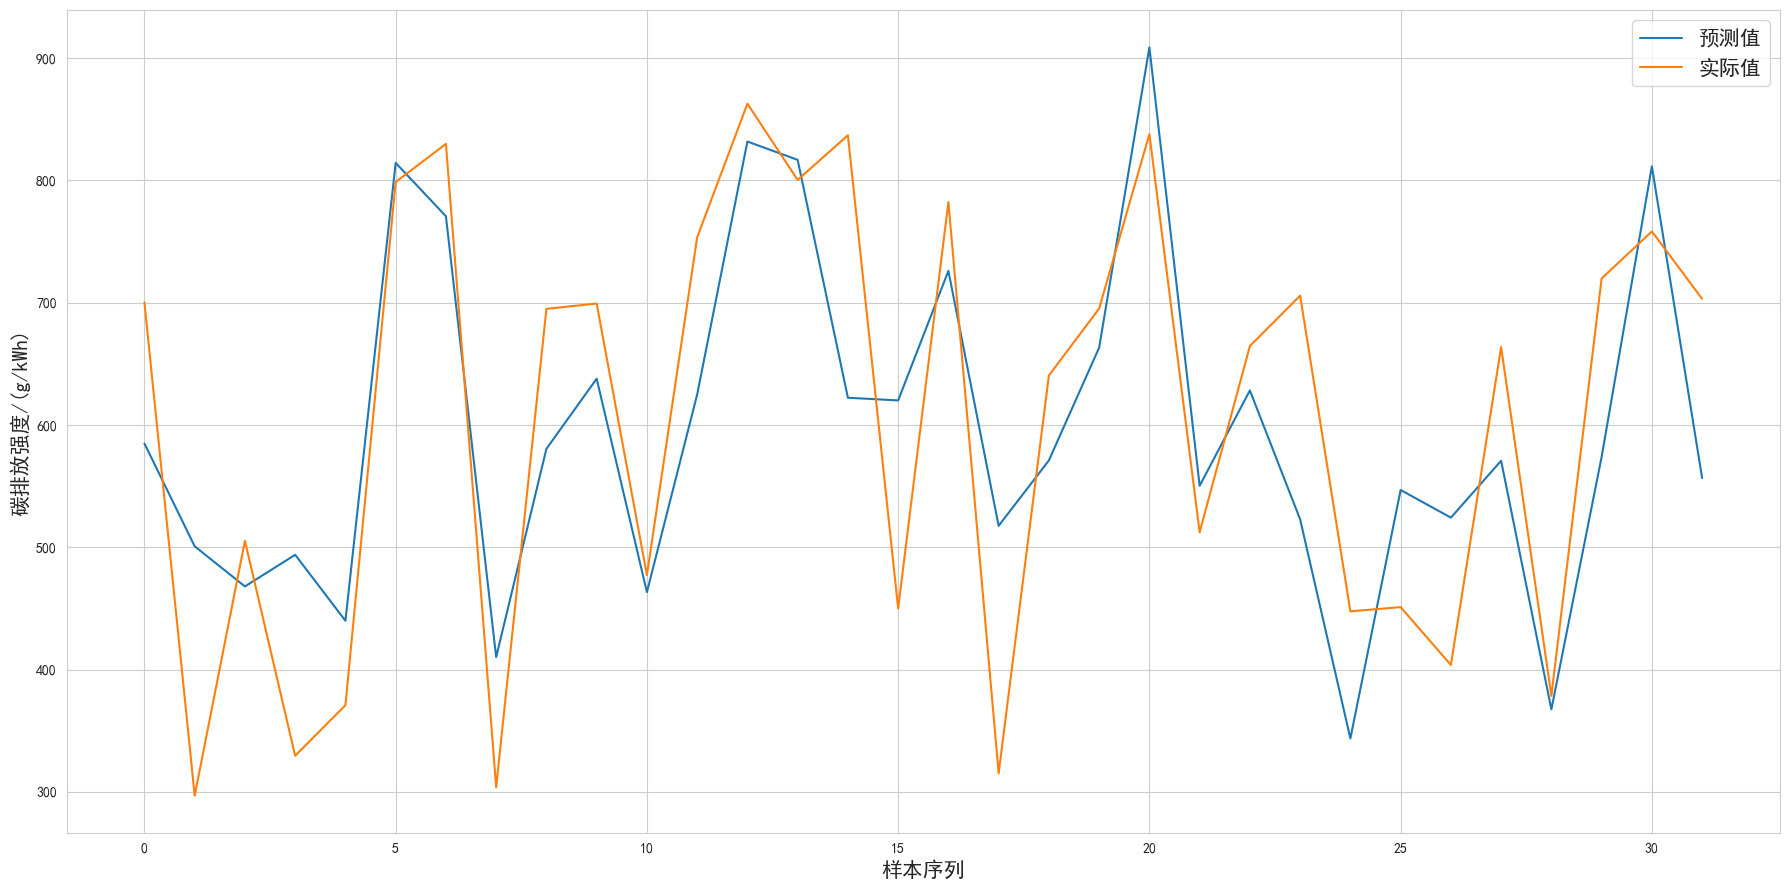

In [16]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体 SimHei
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
# 绘制test data预测值和真实值
plt.figure(figsize=(18, 9))
plt.plot(dnn_y_pred_B, label='预测值')       # 添加预测值的标签
plt.plot(y1_test.values, label='实际值')  # 添加真实值的标签

# 显示图例
plt.legend(fontsize=15)
plt.xlabel("样本序列",fontsize = 15,fontweight='bold')
plt.ylabel("碳排放强度/(g/kWh)",fontsize = 15,fontweight='bold')

# 显示图表
plt.tight_layout()  # 调整布局，确保所有元素不重叠
# plt.savefig("svm.png",dpi=500,bbox_inches='tight')
plt.show()